In [1]:
# Kernel -> py311ml
# Imports aquí ->
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import shap
import category_encoders as ce
from shap import SamplingExplainer
from scipy.stats import mannwhitneyu, pointbiserialr

from category_encoders import BinaryEncoder, CountEncoder, OrdinalEncoder, TargetEncoder

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     StratifiedShuffleSplit, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder,
                                   MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder as SklearnOrdinalEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from imblearn.under_sampling import EditedNearestNeighbours, AllKNN, TomekLinks, RandomUnderSampler, CondensedNearestNeighbour 
from imblearn.pipeline import Pipeline as ImbPipeline
import itertools

In [2]:
# import importlib
# import subprocess
# import sys

# def ensure_package(pkg_name):
#     if importlib.util.find_spec(pkg_name) is None:
#         print(f"Instalando {pkg_name}…")
#         subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
#     else:
#         print(f"{pkg_name} ya está instalado.")

# ensure_package("skrebate")
# from skrebate import ReliefF

Primeramente vamos a leer el archivo y comprobar las variables, con sus tipos de dato

In [138]:
data = pd.read_csv('src/adult.data', header=None, sep=',\s', na_values=["?"], engine='python')
data.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']


def check_df(dataframe, head=5):
    print("------------ Shape ------------")
    print(dataframe.shape)
    print("------------ Types ------------")
    print(dataframe.dtypes)
    
check_df(data)

------------ Shape ------------
(32561, 15)
------------ Types ------------
age                int64
workclass         object
final-weight       int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


Comprobamos que variables contienen valores perdidos 

In [139]:
data.isnull().sum()

age                  0
workclass         1836
final-weight         0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Ahora con ayuda de graficas, visualizamos la distribucion de las variables anteriores


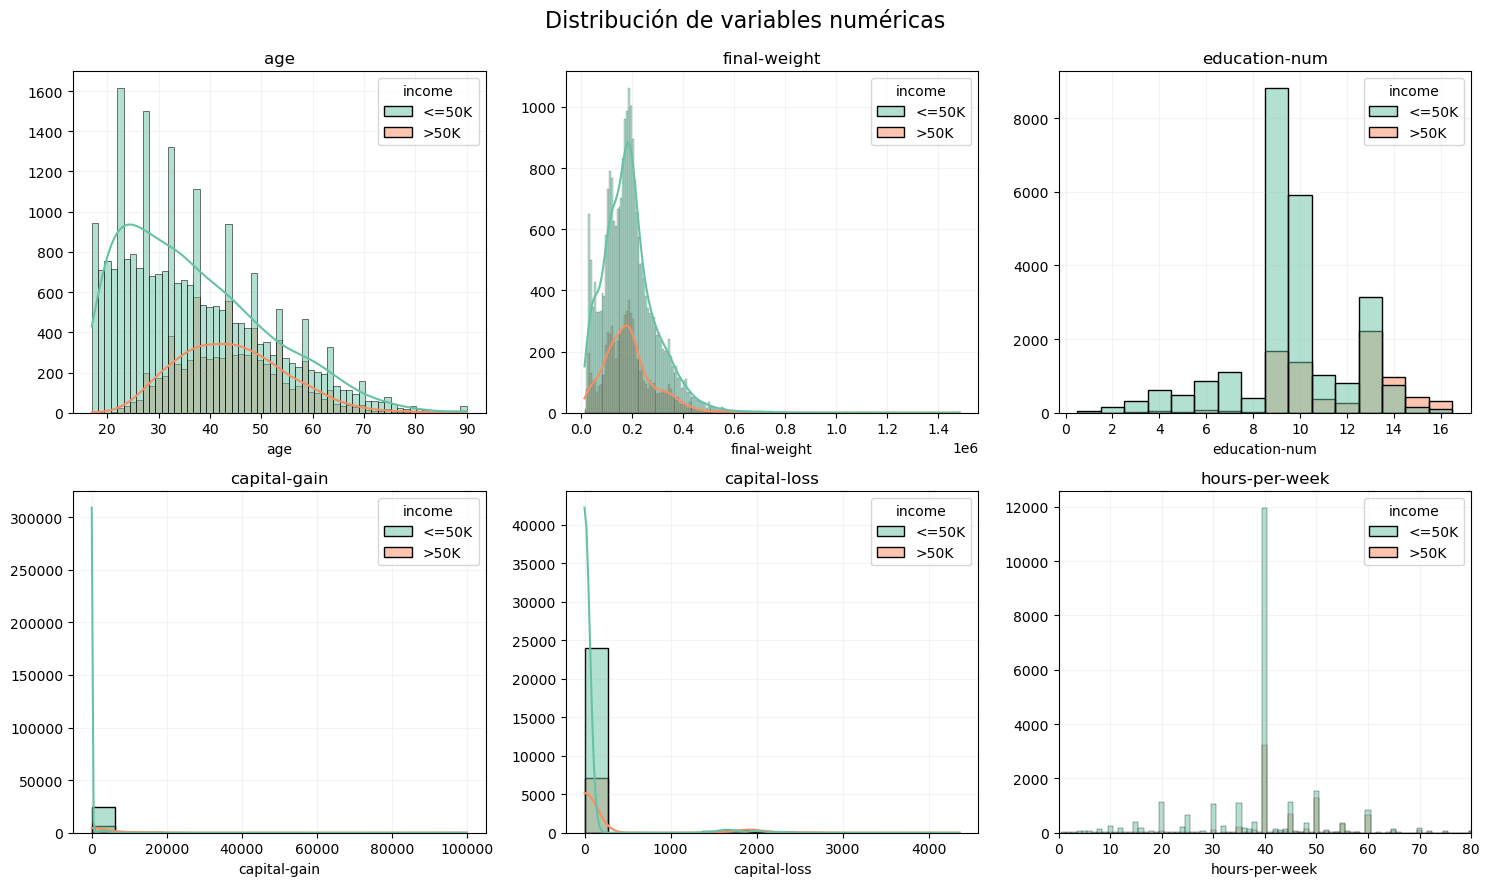

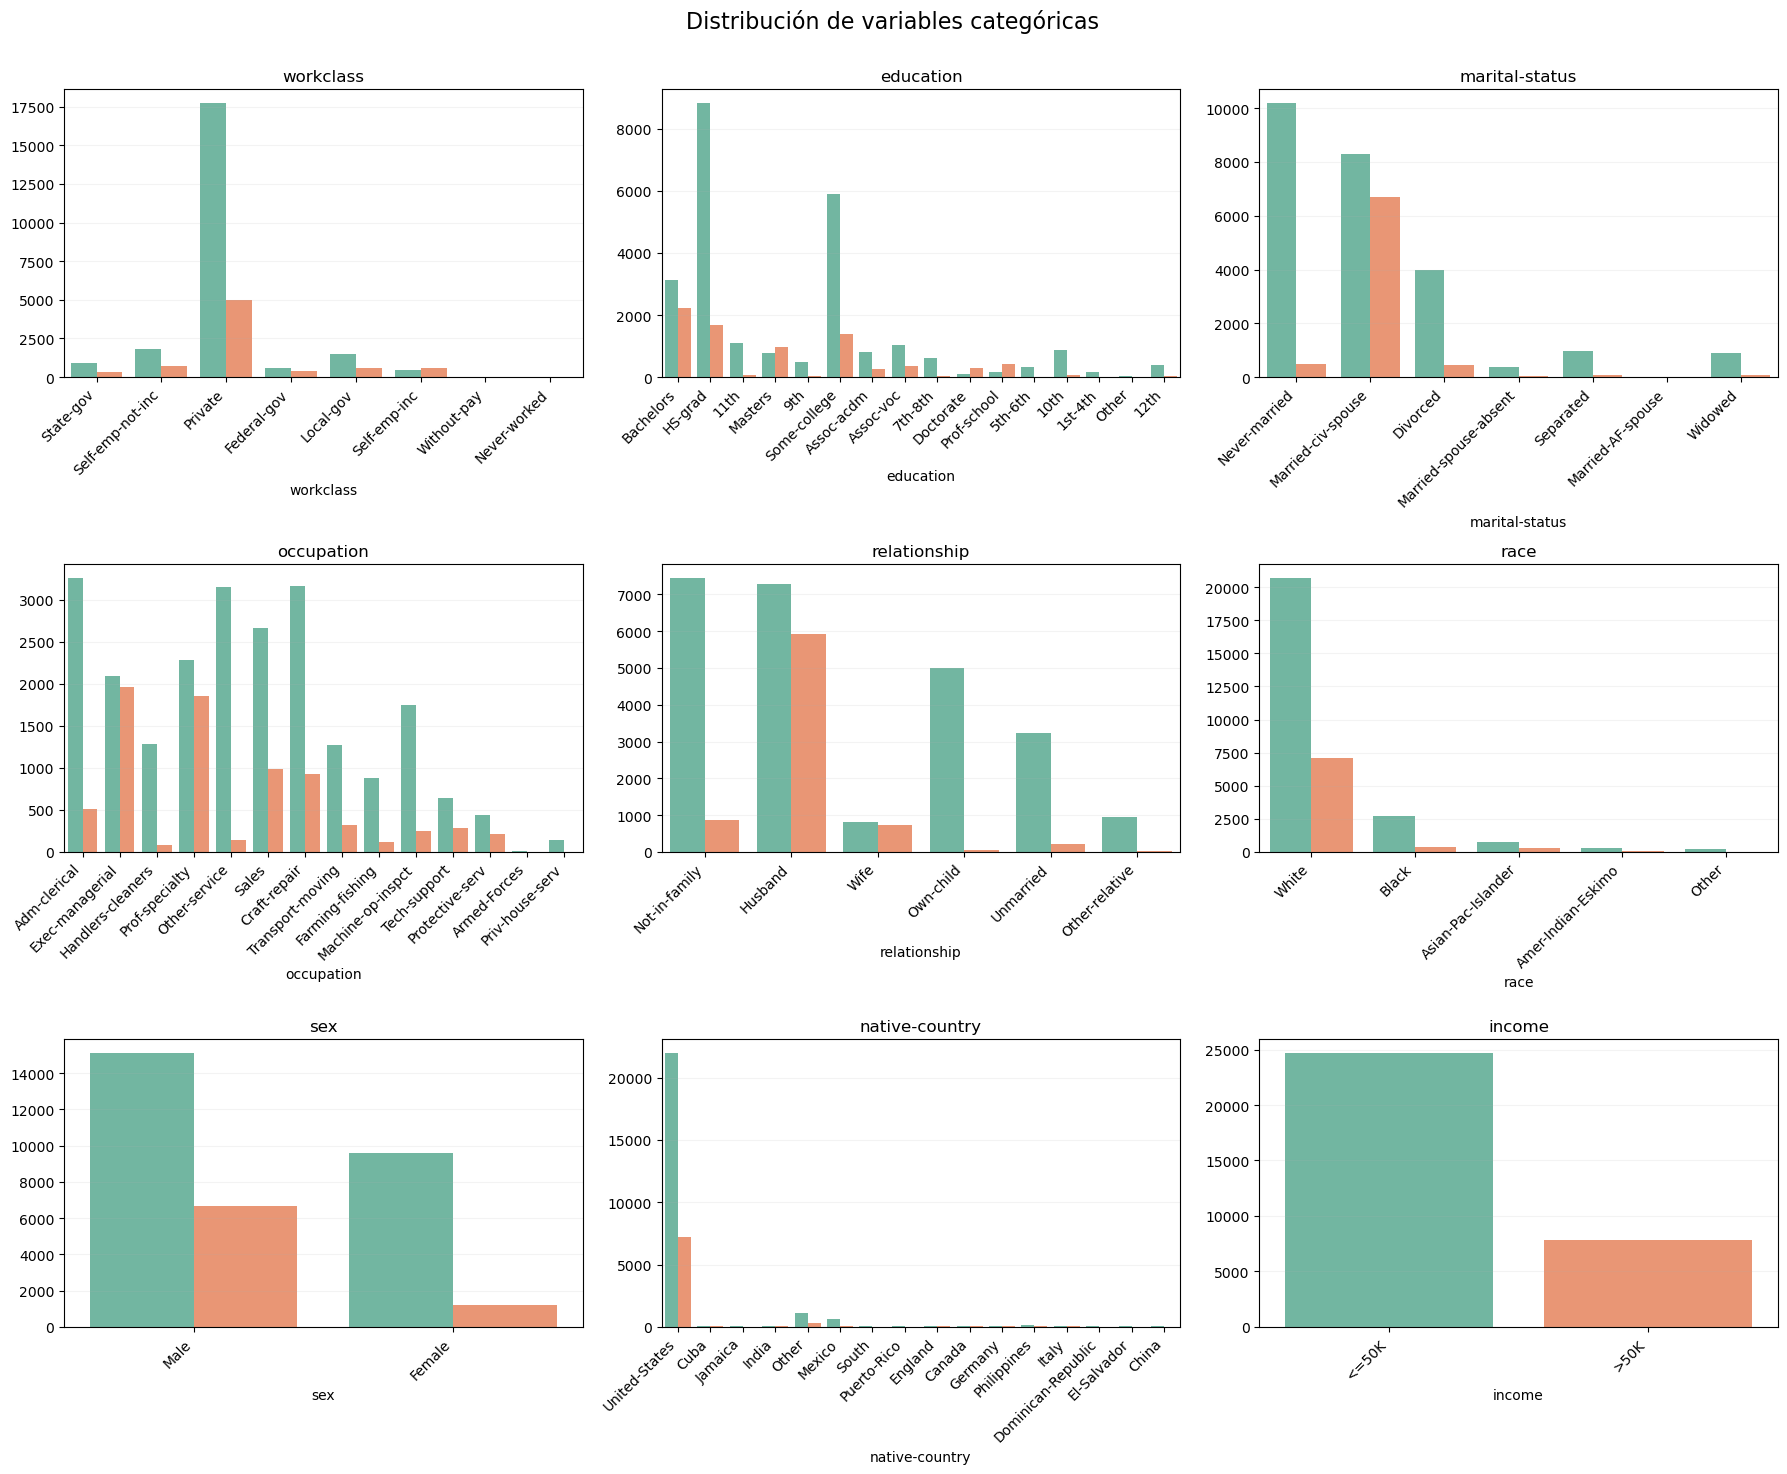

In [18]:
# NUMÉRICAS
def mostrar_distribuciones ():
    numeric_cols  = data.select_dtypes(include=["int64", "float64"]).columns
    discrete_vars = ["education-num", "hours-per-week"]   # tratadas como discretas
    plt.style.use("default")
    palette = "Set2"

    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4.5*n_rows))

    for ax, col in zip(axes.flat, numeric_cols):
        discrete_flag = col in discrete_vars

        sns.histplot(
            x=data[col],
            hue=data["income"],
            palette=palette,
            alpha=.5,
            ax=ax,
            kde=False if discrete_flag else True,
            bins="auto",
            discrete=discrete_flag,
            kde_kws={"bw_adjust": 1.5} if not discrete_flag else None,
        )
        if col == "hours-per-week":
            ax.set_xlim(0, 80)

        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("")
        ax.grid(True, alpha=.15)

    # desactiva ejes vacíos si los hubiera
    for ax in axes.flat[len(numeric_cols):]:
        ax.set_visible(False)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Distribución de variables numéricas", fontsize=16)
    plt.show()

    #CATEGÓRICAS
    cat_cols = data.select_dtypes(include="object").columns
    TOP_N    = 15

    n_cols_c = 3
    n_rows_c = (len(cat_cols) + n_cols_c - 1) // n_cols_c
    fig_c, axes_c = plt.subplots(n_rows_c, n_cols_c, figsize=(6*n_cols_c, 5*n_rows_c))

    def _wrap(label):
        if len(label) > 15:
            return label.replace("-", "\n") if "-" in label else textwrap.fill(label, 9)
        return label

    for ax, col in zip(axes_c.flat, cat_cols):
        freq = data[col].value_counts()
        if len(freq) > TOP_N:
            top_vals = freq.index[:TOP_N]
            data_plot = data.copy()
            data_plot[col] = data_plot[col].where(
                data_plot[col].isin(top_vals), other="Other"
            )
        else:
            data_plot = data

        sns.countplot(
            data=data_plot,
            x=col,
            hue="income",
            palette=palette,
            ax=ax,
        )
        ax.set_title(col)
        ax.set_ylabel("")
        for lbl in ax.get_xticklabels():
            lbl.set_text(_wrap(lbl.get_text()))
            lbl.set_rotation(45)
            lbl.set_ha("right")

        if ax.legend_:
            ax.legend_.remove()
        ax.grid(True, axis="y", alpha=.15)

    for ax in axes_c.flat[len(cat_cols):]:
        ax.set_visible(False)

    fig_c.tight_layout(rect=[0, 0, 1, 0.95])
    fig_c.suptitle("Distribución de variables categóricas", fontsize=16)
    plt.show()
mostrar_distribuciones()

PAIR-PLOT con variables numéricas 

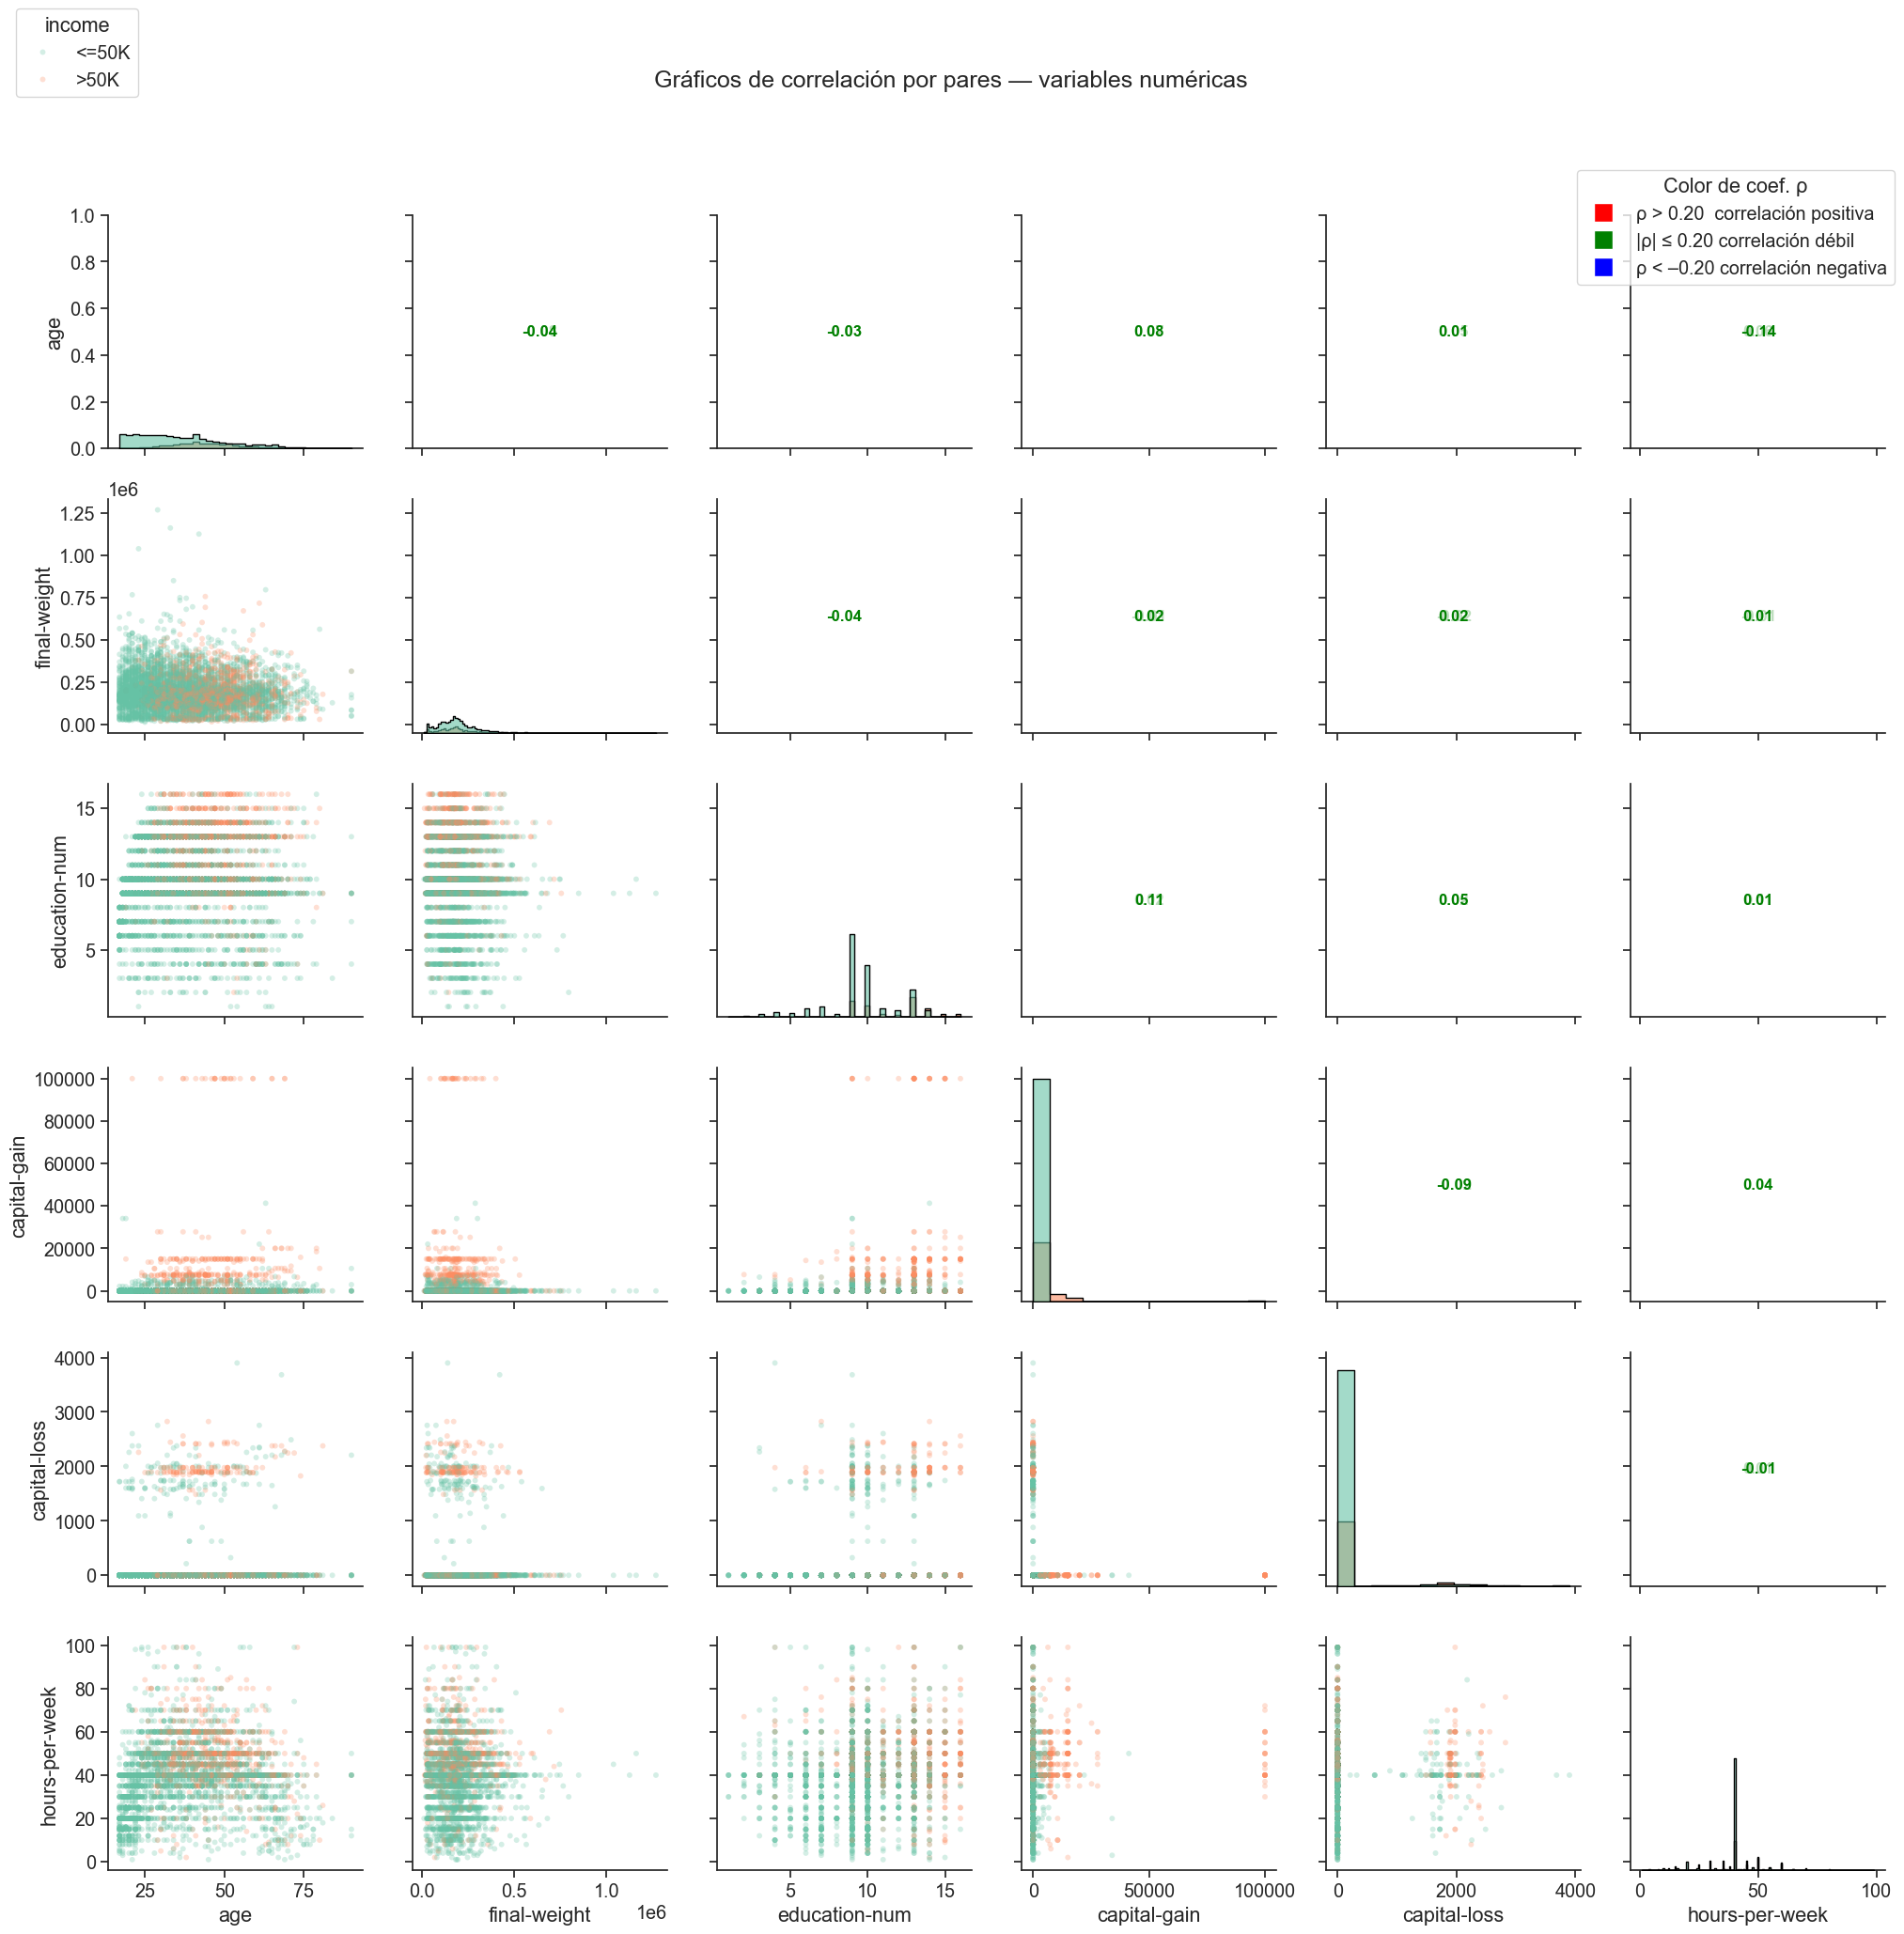

In [20]:
def mostrar_pair_plot():
    sns.set_theme(style="ticks", font_scale=1.3)
    num_cols = ["age", "final-weight", "education-num",
                "capital-gain", "capital-loss", "hours-per-week"]
    df = data[num_cols + ["income"]].sample(min(6000, len(data)), random_state=7)

    g = sns.PairGrid(df, vars=num_cols, hue="income",
                    palette=palette, height=3.2, aspect=1)

    g.map_lower(sns.scatterplot, alpha=.28, s=18, linewidth=0)
    g.map_diag(sns.histplot, element="step", bins="auto",
            alpha=.6, edgecolor="black")

    def annotate_corr(x, y, **kws):
        r = np.corrcoef(x, y)[0, 1]
        if abs(r) < 0.005:          # ❶ omite “0.00”
            return
        ax = plt.gca()
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        color = "red" if r > .20 else "blue" if r < -.20 else "green"
        ax.text(.5, .5, f"{r:.2f}", ha='center', va='center',
                transform=ax.transAxes, fontsize=12, weight='bold',
                color=color,
                bbox=dict(boxstyle="round,pad=0.25",
                        fc="white", ec="none", alpha=.75))
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    g.add_legend(title="income", frameon=True,
                bbox_to_anchor=(0.01, 1.02), loc="lower left")


    g.map_upper(annotate_corr)

    # Leyenda
    legend_elems = [
        Line2D([0], [0], marker='s', color='white',
            label='ρ > 0.20  correlación positiva', markerfacecolor='red', markersize=15),
        Line2D([0], [0], marker='s', color='white',
            label='|ρ| ≤ 0.20 correlación débil', markerfacecolor='green', markersize=15),
        Line2D([0], [0], marker='s', color='white',
            label='ρ < –0.20 correlación negativa', markerfacecolor='blue', markersize=15)
    ]
    g.fig.legend(handles=legend_elems, title="Color de coef. ρ",
                bbox_to_anchor=(0.995, 0.99), loc="upper right", frameon=True)

    g.fig.suptitle("Gráficos de correlación por pares — variables numéricas",
                fontsize=18, y=1.04)

    plt.tight_layout()
    plt.show()
mostrar_pair_plot()

Correlación punto-biserial entre cada variable numérica e income

In [7]:
num_cols = ["age", "final-weight", "education-num",
            "capital-gain", "capital-loss", "hours-per-week"]

r_pb = {col: pointbiserialr(data["income"].eq(">50K").astype(int), data[col])[0]
         for col in num_cols}

pd.Series(r_pb).sort_values(ascending=False)


education-num     0.335154
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
capital-loss      0.150526
final-weight     -0.009463
dtype: float64

OUTLIERS CON MEDIANA

In [8]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].median()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.median[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON MEDIA

In [9]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].mean()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.mean[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON LIMITE SUPERIOR - INFERIOR

In [10]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        X = pd.DataFrame(X)
        Xaux = X.copy()

        # Estadísticos guardados en fit
        IQRs      = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs

        # Para cada columna, winsorizamos
        for c in self.columns:
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]

        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
    from sklearn.base import TransformerMixin

class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Calculamos y guardamos media y desviación por columna
        self.mean_ = X.mean()
        self.std_  = X.std()
        return self
    
    def transform(self, X):
        Xaux = pd.DataFrame(X).copy()
        # Cálculo de límites por columna
        limiteInf = self.mean_ - self.k * self.std_
        limiteSup = self.mean_ + self.k * self.std_
        
        # Winsorización
        for c in Xaux.columns:
            # Máscaras
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            # Sustitución por límites
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]
        
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def get_params(self, deep=True):
        return {"k": self.k}


Version para usar con column transformer y meter este paso en la pipeline


In [143]:
def rellenarModa(data):
    dataCopiada = data.copy()
    # Si 'columnas' no es una lista, se convierte en una lista
    columnas = dataCopiada.columns[dataCopiada.isnull().any()].tolist()
    for columna in columnas:
        if (columna != "native-country"):
        # Calcula la moda de la columna y rellena los valores nulos
            moda = dataCopiada[columna].mode(dropna = True)
            dataCopiada[columna] = dataCopiada[columna].fillna(moda[0])
    return dataCopiada

imputador_modas = FunctionTransformer(rellenarModa, validate=False)

In [ ]:
def rellenarKnn(data):
    columna = "native-country"
    dataCopiada = data.copy()
    columnas_categoricas = dataCopiada.select_dtypes(include=['object']).columns
    encoder = OrdinalEncoder(handle_missing= "return_nan")
    dataCopiada[columnas_categoricas] = encoder.fit_transform(dataCopiada[columnas_categoricas])
    
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    dataImputada = imputer.fit_transform(dataCopiada)
    dataImputada = pd.DataFrame(dataImputada, columns=dataCopiada.columns)
    dataImputada[columna] = dataImputada[columna].round().astype(int)
    dataImputada[columnas_categoricas] = encoder.inverse_transform(dataImputada[columnas_categoricas])
    return dataImputada
imputador_knn = FunctionTransformer(rellenarKnn, validate=False)

Pipeline

In [145]:
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import VarianceThreshold

def transformar_income(X): 
    """Transforma la columna 'income' en una variable binaria."""

    X = X.copy()
    X['income'] = X['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    return X

def separar_x_y(data):
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

def separar_x_y_col(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    return X, y

def transformar_categoricas_a_binarias(X): 

    X = X.copy()
    variables_categoricas_binarias = X.select_dtypes(include=['object']).columns
    dummies = pd.get_dummies(X, columns=variables_categoricas_binarias)
    if hasattr(transformar_categoricas_a_binarias, 'dummy_columns'):
        dummies = dummies.reindex(columns=transformar_categoricas_a_binarias.dummy_columns, fill_value=0)
    else:
        transformar_categoricas_a_binarias.dummy_columns = dummies.columns
    return dummies
def crear_sex_country(X):
    X = X.copy()
    X["sex-native-country"] = X["sex"] + "-" + X["native-country"]
    X = eliminar_columna(X, 'sex')
    X = eliminar_columna(X, "native-country")
    return X

def crear_capital_balance(X):
    X = X.copy()
    X['capital-balance'] = np.sqrt(X['capital-gain'] - X['capital-loss'])
    # X.drop(columns=['capital-gain', 'capital-loss'])
    return X

def log_numerical(X, columna):
    X = X.copy()
    nueva_col = "log-" + columna
    X[nueva_col] = np.log(X[columna] + 1)
    return X

def log_capital_gain_loss_finalWeight(X):
    X = X.copy()
    X = log_numerical(X, 'capital-gain')
    X = log_numerical(X, 'capital-loss')
    X = log_numerical(X, 'final-weight')
    return X

def knnImp(X, y):
    y = y.copy()
    indicesNulos = np.where(y == -1)[0] 
    indicesNoNulos = np.where(y != -1)[0] 
    X_train = X.iloc[indicesNoNulos]
    X_test = X.iloc[indicesNulos]
    y_train = y[indicesNoNulos]

    
    knn = KNeighborsClassifier(n_neighbors= 3)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    y[indicesNulos] = pred
    return y

def eliminar_columna(data, col):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    return data.drop(columns=[col], errors="ignore")

def mannwhitney_score(X, y):
    """
    Para cada columna en X (asumiendo problema binario):
      - calcula mannwhitneyu entre los dos grupos de y
      - devuelve (estadísticos U, p-valores)
    """
    classes = np.unique(y)
    if len(classes) != 2:
        raise ValueError("Mann-Whitney sólo para problemas con 2 clases")
    
    n_feats = X.shape[1]
    stats = np.zeros(n_feats)
    pvals = np.ones(n_feats)
    
    for i in range(n_feats):
        xi = X[:, i]
        # extraemos los dos grupos
        grp0 = xi[y == classes[0]]
        grp1 = xi[y == classes[1]]
        stat, p = mannwhitneyu(grp0, grp1, alternative='two-sided')
        stats[i] = stat
        pvals[i] = p
    
    return stats, pvals

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, threshold=0.5):
        self.estimator = estimator
        self.threshold = threshold

    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        probs = self.estimator.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

binary_transformer = FunctionTransformer(transformar_categoricas_a_binarias)
eliminar_relationship = FunctionTransformer(eliminar_columna, kw_args={"col": ["relationship"]}, validate=False)
eliminar_marital_status = FunctionTransformer(eliminar_columna, kw_args={"col": ["marital-status"]}, validate=False)
eliminar_education = FunctionTransformer(eliminar_columna, kw_args={"col": ["education"]}, validate=False)
sex_country = FunctionTransformer(crear_sex_country, validate=False)
crear_col_capital_balance = FunctionTransformer(crear_capital_balance, validate=False)
crear_col_log_numerical = FunctionTransformer(log_capital_gain_loss_finalWeight, validate = False)

data_binary_income = transformar_income(data)
X, X_val = train_test_split(data_binary_income, test_size=0.2, random_state=34)
X, y = separar_x_y(X)
X_val, y_val = separar_x_y(X_val)

# X, occupation = separar_x_y_col(X, "occupation")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# X_transformed = binary_transformer.transform(X)
# occupationNombre = occupation.copy()
# valoresOccupation = occupationNombre.dropna()
# colConNulos = pd.Categorical(occupation, ordered= True).codes #Paso la variable a ordinal 

# occupation_ord = knnImp(X_transformed, colConNulos) #Imputo los valores
# occupation_series = pd.Series(occupation_ord)
# occupation_mapeados = occupation_series.map(lambda x: occupationNombre[x])

# occupationOHE = pd.get_dummies(occupation_mapeados)
# X_transformed = pd.concat([X_transformed, occupationOHE], axis = 1) #Todas las columnas sin nulos y en OHE


numeric_transformer = Pipeline(steps=[
    # ('outlier_detection', OutlierDetecion_treatment_MeanStd(k=3)),
    # ('outlier_detection', OutlierDetecion_treatment_IQR(k=5)),
    # ('crear_capital_balance', crear_col_capital_balance),
    # ('log_capital_gain_loss_final_weight', crear_col_log_numerical)
    # ('scaler', RobustScaler())
    ('scaler', StandardScaler()), 
    # ('scaler', MinMaxScaler()) Descartado despues de las pruebas
    ('imputer_after', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline(steps=[
    # ('eliminar_variable_relationship', eliminar_relationship),
    # ('eliminar_variable_relationship', eliminar_education),
    # ('crear_sex_country', sex_country), #Aumenta un poco la carga computacional
    # ('one_hot_encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    # ('binary_transformer', BinaryEncoder(handle_unknown='value', handle_missing='value')),
    ('ordinal_transformer', OrdinalEncoder(handle_unknown='-1')),
    ('imputer_after', SimpleImputer(strategy='constant', fill_value=-1)),
    # ('target_transformer', TargetEncoder(handle_unknown='value', handle_missing='value')),
    # ('count_transformer', CountEncoder( handle_unknown='value', handle_missing='value')),
])

preprocessorBasic = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features),
    ])

# Definimos el pipeline con el transformador
pipeline = ImbPipeline([
    
    ('valores_perdidos',     imputador_modas),
    ('ocupation_perdidos', imputador_knn),

    ('preprocesador',  preprocessorBasic),

    # ('anova',        SelectKBest(score_func=f_classif, k=50)),
    # ('man-white',    SelectKBest(score_func=mannwhitney_score, k=50)),
    # ('relief',       ReliefF(n_neighbors=10, n_features_to_select=50)), Demasiado costoso computacionalmente
    # ('wrapper',      RFE(estimator=LogisticRegression(), n_features_to_select=25, step=3)), # Seleccionado como el mejor metodo de seleccion

    # ('enn', EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)),
    # ('allknn', AllKNN(n_neighbors=10, n_jobs=-1)),
    # ('tomek_links', TomekLinks(sampling_strategy='auto', n_jobs=-1)),
    
    # ('random_undersample', RandomUnderSampler(sampling_strategy='auto')),
    # ('condensed_nearest_neighbour', CondensedNearestNeighbour(n_neighbors=3, n_jobs=-1, sampling_strategy='auto')),
    # ('tomek_links', TomekLinks(sampling_strategy='auto', n_jobs=-1)),
    # ('variance_threshold', VarianceThreshold(threshold=0.03)),
    # ('pca', PCA(svd_solver='full')),
    ('classifier',   KNeighborsClassifier())
    # ('classifier', DecisionTreeClassifier())
    # ('classifier_umbral', ThresholdClassifier(KNeighborsClassifier(), threshold=0.25)),
    # ('classifier_umbral', ThresholdClassifier(DecisionTreeClassifier(), threshold=0.1)),
])

pipeline.fit(X, y.to_numpy())
predicciones = pipeline.predict(X)
probas = pipeline.predict_proba(X)[:, 1]
predicciones_val = pipeline.predict(X_val)
probas_val = pipeline.predict_proba(X_val)[:, 1]
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, probas))
print("AUC en Val :", roc_auc_score(y_val, probas_val))
print("Recall medio por clase: ", recall_score(y, predicciones, average='macro'))
print("Recall medio por clase en Val: ", recall_score(y_val, predicciones_val, average='macro'))  


Accuracy: 0.8798372235872236
Confusion Matrix:
 [[18604  1191]
 [ 1939  4314]]
AUC: 0.9395851537107098
AUC en Val : 0.8372869490723573
Recall medio por clase:  0.814871067495079
Recall medio por clase en Val:  0.7305628508227954


Grid

In [ ]:
param_grid_knn = {
    'pca__n_components': [0.8, 0.9, 0.95],
    'classifier__n_neighbors' : [10, 50, 100],
    'classifier__weights'     : ['uniform', 'distance'],
    'classifier__metric'      : ['euclidean', 'manhattan'],
}
param_grid_tree = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [10, 20, 30, 50],
    'classifier__min_samples_split' : [0.0001, 0.001, 0.01],
    'classifier__min_samples_leaf' : [5, 10, 20, 50, 100],
    'classifier__ccp_alpha' : [0.0, 0.01, 0.1],
    # 'classifier__min_impurity_decrease' : [0.0, 0.1, 0.2],    
}    

param_grid_wrapper = {
    'wrapper__n_features_to_select': [20,25,30, 35, 40],
    'wrapper__step': [1, 3, 5]
}

# --------------------------------------------------------------------
# 3.  Configuración del GridSearch ------------------------------------
# --------------------------------------------------------------------
holdout = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42)  # 80 % / 20 %

grid = GridSearchCV(
    estimator=pipeline,
    # param_grid=param_grid_tree,
    param_grid=param_grid_knn,
    # param_grid = param_grid_wrapper,
    cv=holdout,
    scoring='roc_auc',         # o 'roc_auc', 'balanced_accuracy', etc.
    n_jobs=-1,                  # paraliza en todos los cores disponibles
    verbose=2,                  # para ver progreso
    refit=True,                 # entrena el modelo final con los mejores parámetros
)

# --------------------------------------------------------------------
# 4.  Ajuste -----------------------------------------------------------
# --------------------------------------------------------------------
data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)

grid.fit(X, y)

print("Mejores hiperparámetros:")
print(grid.best_params_)
print(f"Mejor media de CV: {grid.best_score_:.4f}")

# El modelo entrenado con los mejores parámetros:
best_model = grid.best_estimator_

best = grid.best_params_
clf_params = {
    key.split('__', 1)[1]: value
    for key, value in best.items()
    if key.startswith('classifier__')
}

print("Pipeline con los mejores hiperparámetros:")
predicciones = best_model.predict(X)
probas = best_model.predict_proba(X)[:, 1]
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, probas))
print("Recall medio por clase: ", recall_score(y, predicciones, average='macro'))

Fitting 1 folds for each of 36 candidates, totalling 36 fits
Mejores hiperparámetros:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 50, 'classifier__weights': 'distance', 'pca__n_components': 0.95}
Mejor media de CV: 0.8200
Pipeline con los mejores hiperparámetros:
Accuracy: 0.9999692884125181
Confusion Matrix:
 [[24719     1]
 [    0  7841]]
AUC: 0.9999999974204135
Recall medio por clase:  0.9999797734627831


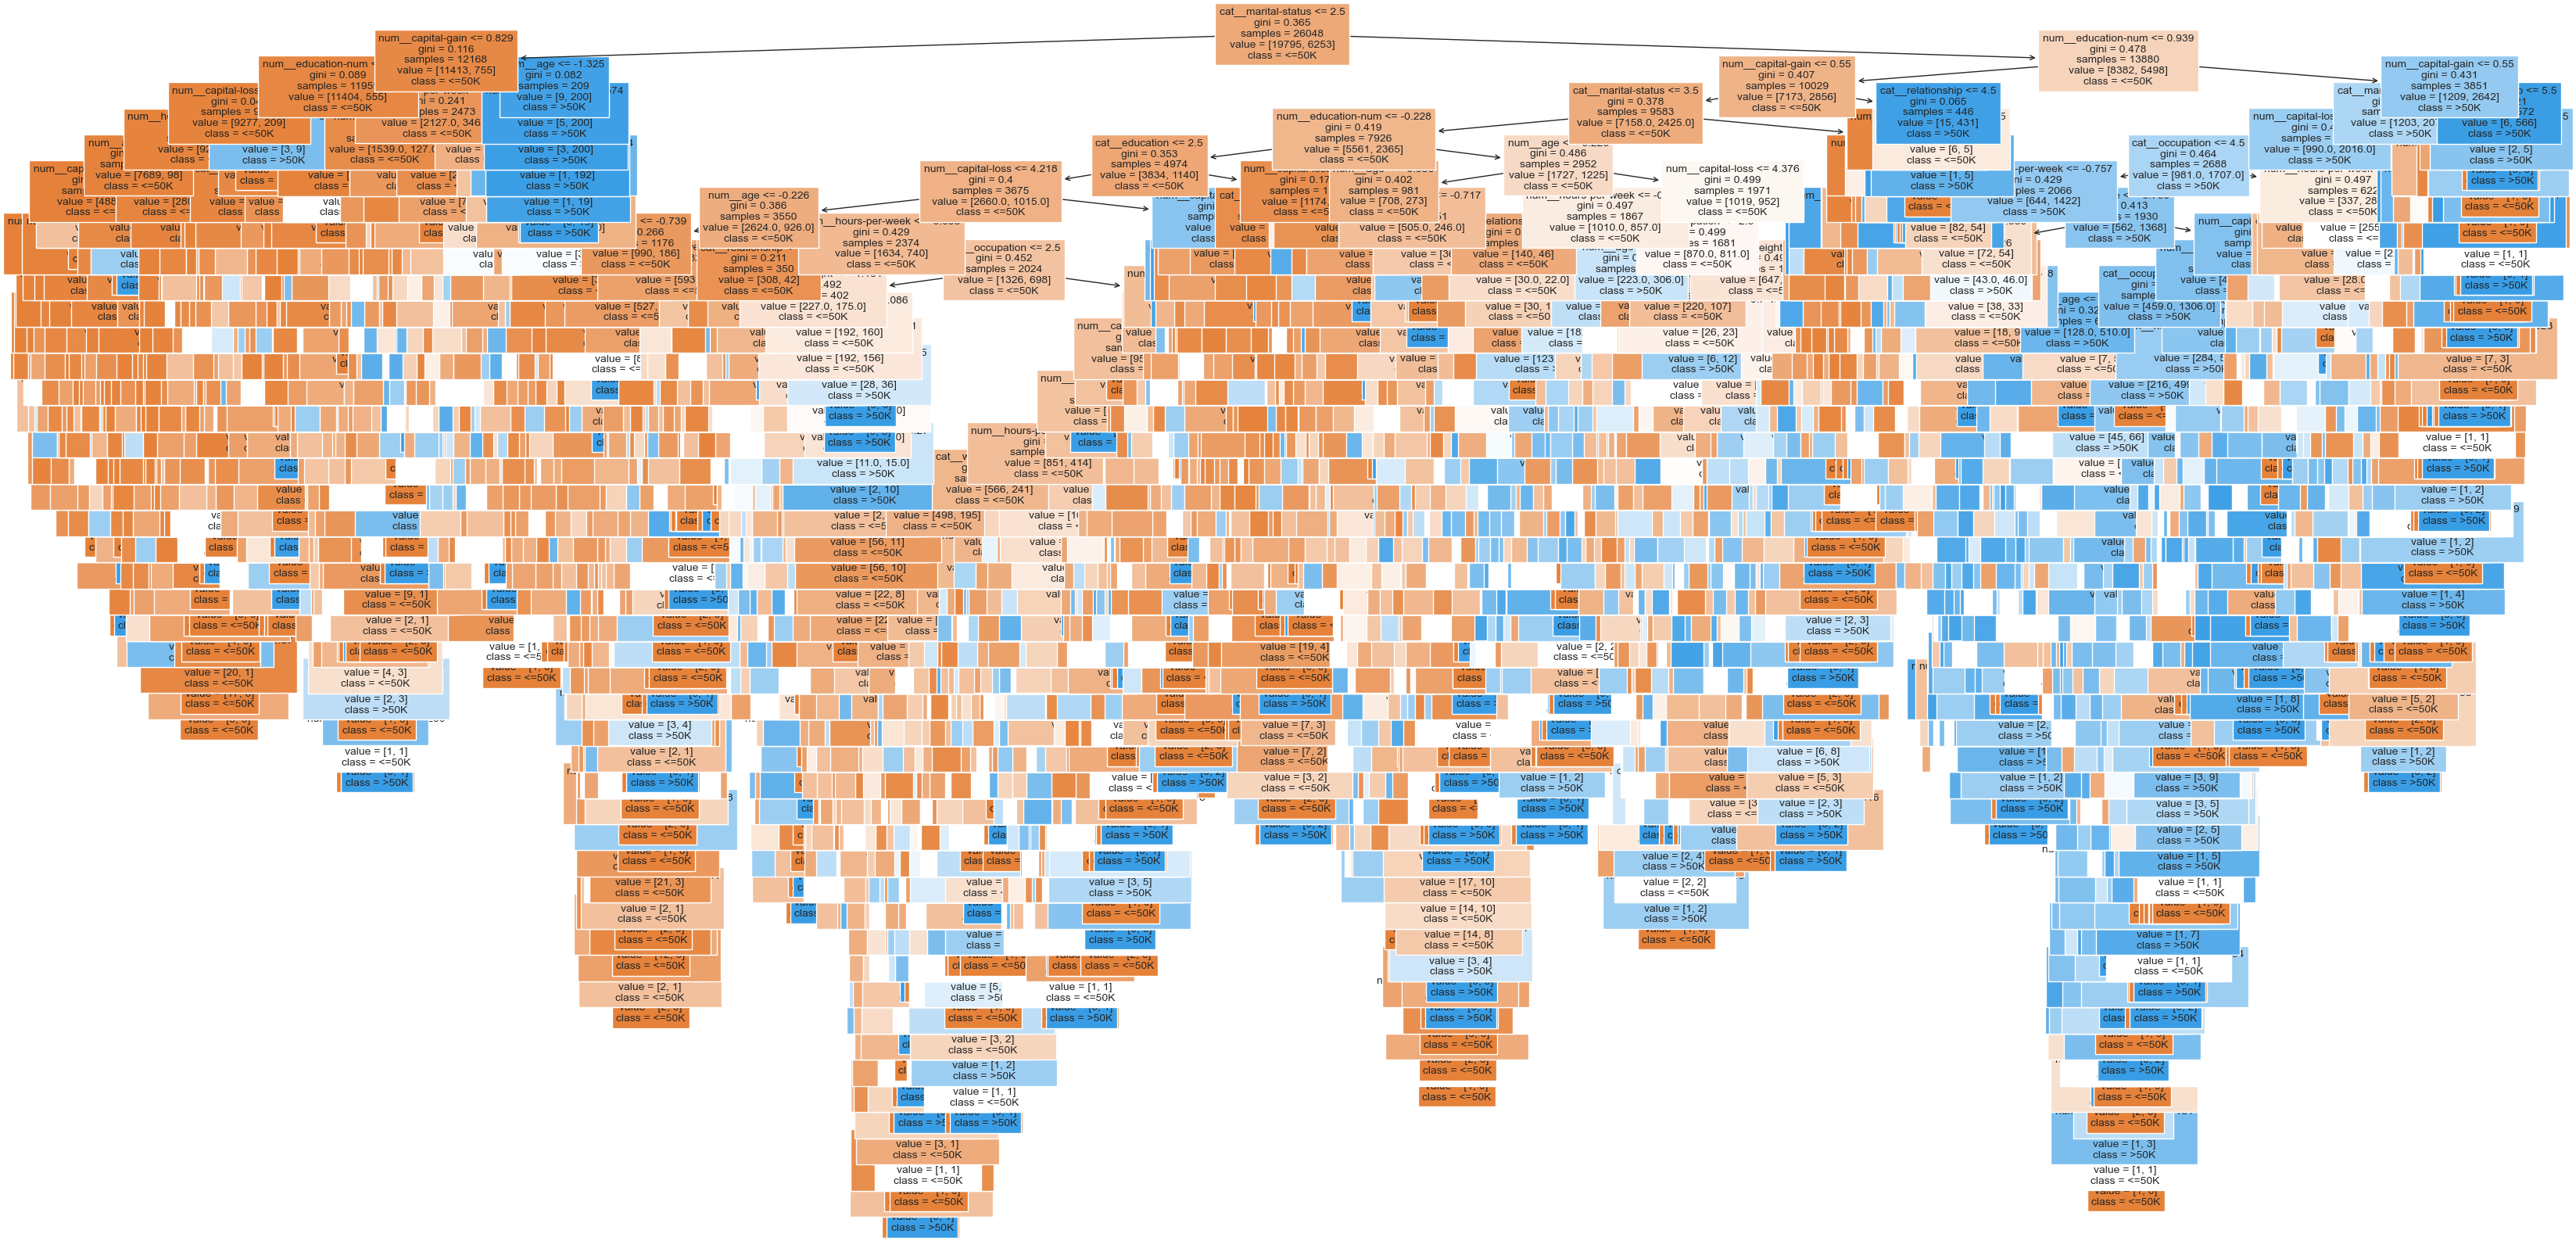

In [26]:

plt.figure(figsize=(40, 20))
feature_names = best_model.named_steps["preprocesador"].get_feature_names_out()
plot_tree(pipeline.named_steps['classifier'], filled=True, fontsize=10, feature_names=feature_names, class_names=["<=50K", ">50K"])
plt.savefig("arbol_decision.pdf",       # nombre y formato
            dpi=300,                    # resolución en puntos por pulgada
            bbox_inches="tight") 

plt.show()

Deshacemos la codificacion ordinal para interpretar

In [34]:

# 1) Ajusta el encoder sobre tu DataFrame original
enc = ce.OrdinalEncoder(cols=['education'], )
enc.fit(X, y)

# 2) Recupera el diccionario de mapeo
mapping = enc.category_mapping[0]['mapping']
#    p.ej. {'Divorced': 0, 'Married-AF-spouse': 1, …, 'Married-civ-spouse': 4, 'Married-spouse-absent': 5, …}

# 3) Invierte el diccionario para poder agrupar por código
inv_map = {code:cat for cat, code in mapping.items()}

# 4) Para threshold = 4.5:
left_codes  = [i for i in inv_map if i <= 3.5]
right_codes = [i for i in inv_map if i >  3.5]

left_cats  = [inv_map[i] for i in sorted(left_codes)]
right_cats = [inv_map[i] for i in sorted(right_codes)]

print("Rama izquierda (≤4.5):", left_cats)
print("Rama derecha (>4.5):", right_cats)


Rama izquierda (≤4.5): [nan, 'HS-grad', 'Prof-school', 'Masters']
Rama derecha (>4.5): ['11th', '10th', '5th-6th', 'Some-college', 'Preschool', 'Bachelors', '9th', 'Assoc-voc', 'Assoc-acdm', '7th-8th', '12th', 'Doctorate', '1st-4th']


Permutation Importance

In [ ]:
result = permutation_importance(pipeline, X, y, scoring='roc_auc', random_state=1) 
# Obtenemos los índices de las variables ordenadas de mayor a menor
sorted_importances_idx = result.importances_mean.argsort()

# Creamos un DataFrame con toda la información y lo mostramos
feature_importances = pd.DataFrame([], index = X.columns[sorted_importances_idx[::-1]], columns=['Media','Desviación Estándard'])
feature_importances['Media'] = result.importances_mean[sorted_importances_idx[::-1]]
feature_importances['Desviación Estándard'] = result.importances_std[sorted_importances_idx[::-1]]
feature_importances

In [ ]:
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in roc_auc score")
ax.figure.tight_layout()

In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.stats import chi2_contingency

# for c in X_transformed.columns:
#     if c in X:  # No es OHE
#         print("")
#     else:
#         contingency_table = pd.crosstab(X_transformed[c], y)  # Tabla de frecuencias

#         chi2, _, _, _ = chi2_contingency(contingency_table)  
#         n = contingency_table.sum().sum()  
#         r, k = contingency_table.shape  

#         if min(r, k) - 1 == 0: #Por si hay una division por cero
#             print("Fallo en ", c, " división por 0")
#             continue
#         q = min(r, k)
#         v = np.sqrt(chi2 / (n * ( q - 1)))  
#         if (v > 0.1):
#             print("La correlacion para ", c, "es de ", v)


Una vez pasadas todas las variables a numericas, podemos ver la matriz de corelacion 

In [ ]:
# X_transformed = binary_transformer.transform(X)
# X_transformed = pd.concat([X_transformed, y], axis=1)
# corr_matrix = X_transformed.corr()
# filtered_corr = corr_matrix.where(corr_matrix != 1)

# plt.figure(figsize=(60,60))
# sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.show()

Se observan varias correlaciones, algunas obvias como marital-status_Married-civ-spouse con relationship_husband y otras que vamos a analizar. Primero vamos a ver las mas influyentes en el propio resultado
 

In [ ]:
# correlations = X_transformed.corr()['income'].sort_values(ascending=False)
# correlations = abs(correlations).sort_values(ascending=False)
# correlations = correlations.drop('relationship_Husband') 
# correlations = correlations.drop('sex_Male')
# correlations = correlations.drop('sex_Female')


# print("Most influential factors:\n", correlations[:6])

Probamos el rendimiento de nuetro modelo con la metrica seleccionada 

In [ ]:
predicciones = pipeline.predict(X)
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, predicciones)) 

Accuracy: 0.8186480759190442
Confusion Matrix:
 [[23433  1287]
 [ 4618  3223]]
AUC: 0.6794907014163786


Probamos el rendimiento de nuestro modelo con el test.data que previamente esta dividio por|1x3 Cross validator

In [28]:
#Quitamos el punto final
def transformar_income_test(X): 
    X = X.copy()
    X['income'] = X['income'].str.strip().str.rstrip('.')
    X['income'] = X['income'].map({'<=50K': 0, '>50K': 1})
    return X

data_test = pd.read_csv('src/adult.test', header=None, skiprows=1, sep=',\s', na_values=["?"], engine='python')
data_test.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                     'hours-per-week', 'native-country', 'income']

data_test = transformar_income_test(data_test)
X_test, y_test = separar_x_y(data_test)
# X_test_transformed = binary_transformer.transform(X_test)


#Predecimos los valores con el conjunto del test
predicciones_test = pipeline.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, predicciones_test))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, predicciones_test))
print("Test AUC:", roc_auc_score(y_test, predicciones_test))



Test Accuracy: 0.8115594865180271
Test Confusion Matrix:
 [[10880  1555]
 [ 1513  2333]]
Test AUC: 0.7407770014057498


SHAP

Globales

In [ ]:
# # 1. DataFrames de referencia
# feature_names = X.columns

# # 2. Función envoltorio
# def model_predict(data):
#     """Asegura que el Pipeline recibe un DataFrame con los nombres correctos."""
#     if not isinstance(data, pd.DataFrame):
#         data = pd.DataFrame(data, columns=feature_names)
#     return pipeline.predict_proba(data)[:, 1]

# # 3. Background y muestra de evaluación
# background = shap.sample(X, 200, random_state=1)     # o shap.kmeans(X, 100)
# X_eval     = shap.sample(X, 500, random_state=1)

# # 4. Explainer (Kernel o Sampling)
# explainer   = shap.KernelExplainer(model_predict, background)
# # explainer = shap.SamplingExplainer(model_predict, background)  # algo más rápido

# shap_values = explainer.shap_values(X_eval, nsamples=200)

# # 5. Gráfico
# shap.summary_plot(shap_values, X_eval)


Individuales 

In [ ]:
# 0. Solo una vez por notebook
shap.initjs()

# 1. Wrapper para el pipeline  ─ convierte ndarray→DataFrame si hace falta
feature_names = X.columns          # guarda los nombres originales

def model_predict(data):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=feature_names)
    return pipeline.predict_proba(data)

# 2. Background pequeño (muestra o k‑means)
background = shap.sample(X, 200, random_state=0)      # o shap.kmeans(X, 100)

# 3. Explainer (Kernel o Sampling) usando la *función*, no el pipeline
explainer = shap.KernelExplainer(model_predict, background)
# explainer = shap.SamplingExplainer(model_predict, background)  # 10 × más rápido

# 4. Fila a explicar
instance = X.iloc[[1]]             # DataFrame de 1 fila

# 5. Cálculo limitado de coaliciones
shap_values = explainer.shap_values(instance, nsamples=200)

# 6. Force plot (clase positiva = 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[0,:,0],             # clase 1, primera fila
    instance
)


Comparativa DT vs KNN con diferentes combinaciones y diferente orden en la pipeline

In [29]:
def comparacion_DTKNN():
    cols = [
        'age','workclass','final-weight','education','education-num','marital-status',
        'occupation','relationship','race','sex','capital-gain','capital-loss',
        'hours-per-week','native-country','income'
    ]
    data = pd.read_csv(
        'src/adult.data', header=None, names=cols,
        sep=',\s', na_values='?', engine='python'
    )
    data = transformar_income(data)

    # dividimos adult.data en train/val (80% train, 20% val)
    X_full, y_full = separar_x_y(data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full,
        test_size=0.2,
        stratify=y_full,
        random_state=42
    )

    #Cargamos y transformamos adult.test como test final
    data_test = pd.read_csv(
        'src/adult.test', header=None, names=cols,
        skiprows=1, sep=',\s', na_values='?', engine='python'
    )
    data_test = transformar_income_test(data_test)
    X_test, y_test = separar_x_y(data_test)

    num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

    num_blocks = {
        "imp":   ("imp",   SimpleImputer(strategy="median")),
        "out":   ("out",   OutlierDetecion_treatment_IQR(k=5)),
        "scale": ("scale", StandardScaler()),
        "poly":  ("poly",  PolynomialFeatures(degree=2, include_bias=False))
    }

    cat_encoders = {
        "OHE":     OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        "Ordinal": OrdinalEncoder(handle_unknown="ignore")
    }
    try:
        from category_encoders import TargetEncoder
        cat_encoders["Target"] = TargetEncoder(handle_unknown="value", handle_missing="value")
    except ImportError:
        pass

    classifiers = {
        "DT":  DecisionTreeClassifier(max_depth=12, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=11, weights="distance")
    }

    def generate_orders():
        extras = ["out","scale","poly"]
        for k in range(0, len(extras)+1):
            for combo in itertools.combinations(extras, k):
                for perm in itertools.permutations(combo):
                    yield ("imp",) + perm

    results = []
    total = len(cat_encoders)*len(classifiers)*len(list(generate_orders()))
    count = 0

    for enc_name, encoder in cat_encoders.items():
        for clf_name, clf in classifiers.items():
            for order in generate_orders():
                count += 1
                tag = f"{clf_name}-{enc_name} [{ '→'.join(order) }]"
                print(f"[{count:3d}/{total}] START {tag}")

                # construye pipeline numérico según el orden
                num_steps = [ num_blocks[s] for s in order ]
                num_pipe  = Pipeline(num_steps)

                # pipeline categórico
                cat_pipe = Pipeline([
                    ("imp", SimpleImputer(strategy="most_frequent")),
                    ("enc", encoder)
                ])

                preprocessor = ColumnTransformer([
                    ("num", num_pipe, num_cols),
                    ("cat", cat_pipe, cat_cols)
                ])

                pipe = Pipeline([
                    ("prep", preprocessor),
                    ("clf",  clf)
                ])

                pipe.fit(X_train, y_train)

                # VALIDACIÓN
                p_val      = pipe.predict_proba(X_val)[:,1]
                y_val_hat  = pipe.predict(X_val)
                auc_val    = roc_auc_score(y_val,    p_val)
                rec_val    = recall_score(y_val,    y_val_hat, average="macro")
                acc_val    = accuracy_score(y_val,   y_val_hat)

                # TEST
                p_test     = pipe.predict_proba(X_test)[:,1]
                y_test_hat = pipe.predict(X_test)
                auc_test   = roc_auc_score(y_test,   p_test)
                rec_test   = recall_score(y_test,   y_test_hat, average="macro")
                acc_test   = accuracy_score(y_test,  y_test_hat)

                results.append({
                    "Model":    clf_name,
                    "Encoder":  enc_name,
                    "Order":    "→".join(order),
                    "Acc_val":  acc_val,
                    "AUC_val":  auc_val,
                    "Rec_val":  rec_val,
                    "Acc_test": acc_test,
                    "AUC_test": auc_test,
                    "Rec_test": rec_test
                })

                print(f"[{count:3d}/{total}] DONE  {tag}  "
                    f"VAL Acc:{acc_val:.3f} AUC:{auc_val:.3f} Rec:{rec_val:.3f}  "
                    f"TEST Acc:{acc_test:.3f} AUC:{auc_test:.3f} Rec:{rec_test:.3f}\n")

    # RESUMEN DE ESTADÍSTICAS
    df = (pd.DataFrame(results)
            .sort_values("AUC_test", ascending=False)
            .head(10)
            .reset_index(drop=True))

    print("\n=== TOP-10 MEJORES por AUC_test ===")
    print(df.to_string(index=False, formatters={
        "Acc_val":  "{:.3f}".format,
        "AUC_val":  "{:.3f}".format,
        "Rec_val":  "{:.3f}".format,
        "Acc_test": "{:.3f}".format,
        "AUC_test": "{:.3f}".format,
        "Rec_test": "{:.3f}".format
    }))

    df = (pd.DataFrame(results)
            .sort_values("AUC_test", ascending=True)
            .head(10)
            .reset_index(drop=True))
    print("\n=== TOP-10 PEORES por AUC_test ===")
    print(df.to_string(index=False, formatters={
        "Acc_val":  "{:.3f}".format,
        "AUC_val":  "{:.3f}".format,
        "Rec_val":  "{:.3f}".format,
        "Acc_test": "{:.3f}".format,
        "AUC_test": "{:.3f}".format,
        "Rec_test": "{:.3f}".format
    }))
comparacion_DTKNN()

[  1/96] START DT-OHE [imp]
[  1/96] DONE  DT-OHE [imp]  VAL Acc:0.850 AUC:0.890 Rec:0.781  TEST Acc:0.848 AUC:0.882 Rec:0.775

[  2/96] START DT-OHE [imp→out]
[  2/96] DONE  DT-OHE [imp→out]  VAL Acc:0.822 AUC:0.838 Rec:0.748  TEST Acc:0.823 AUC:0.835 Rec:0.743

[  3/96] START DT-OHE [imp→scale]
[  3/96] DONE  DT-OHE [imp→scale]  VAL Acc:0.850 AUC:0.890 Rec:0.781  TEST Acc:0.848 AUC:0.882 Rec:0.775

[  4/96] START DT-OHE [imp→poly]
[  4/96] DONE  DT-OHE [imp→poly]  VAL Acc:0.852 AUC:0.875 Rec:0.765  TEST Acc:0.853 AUC:0.872 Rec:0.759

[  5/96] START DT-OHE [imp→out→scale]
[  5/96] DONE  DT-OHE [imp→out→scale]  VAL Acc:0.822 AUC:0.838 Rec:0.748  TEST Acc:0.823 AUC:0.835 Rec:0.743

[  6/96] START DT-OHE [imp→scale→out]
[  6/96] DONE  DT-OHE [imp→scale→out]  VAL Acc:0.822 AUC:0.839 Rec:0.748  TEST Acc:0.823 AUC:0.835 Rec:0.743

[  7/96] START DT-OHE [imp→out→poly]
[  7/96] DONE  DT-OHE [imp→out→poly]  VAL Acc:0.813 AUC:0.816 Rec:0.731  TEST Acc:0.817 AUC:0.816 Rec:0.733

[  8/96] START D

KeyboardInterrupt: 